In [78]:
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import pandas as pd
import scipy
%config InlineBackend.figure_format = 'svg' 

from clickhouse_driver import Client

client = Client('oleg.orbita.work', port = 9000, user='student_ml',
password='CGRV8zemLGgsfdz7Uc6ZJeisGTcPQa', settings={'use_numpy': True})

table_name = 'students_datas. house_train'
df = client.query_dataframe(f"SELECT * FROM {table_name}")

pd.options.display.max_columns = None
pd.options.display.max_rows = None

2.1. Сколько данных в датасете?

2.2. Сколько параметров? Выведите список всех параметров.

In [79]:
df.info(verbose=True, show_counts=False)  # 1460 записей, 81 полей

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Dtype   
---  ------         -----   
 0   Id             int16   
 1   MSSubClass     int16   
 2   MSZoning       category
 3   LotFrontage    object  
 4   LotArea        int64   
 5   Street         category
 6   Alley          object  
 7   LotShape       category
 8   LandContour    category
 9   Utilities      category
 10  LotConfig      category
 11  LandSlope      category
 12  Neighborhood   category
 13  Condition1     category
 14  Condition2     category
 15  BldgType       category
 16  HouseStyle     category
 17  OverallQual    int8    
 18  OverallCond    int8    
 19  YearBuilt      int16   
 20  YearRemodAdd   int16   
 21  RoofStyle      category
 22  RoofMatl       category
 23  Exterior1st    category
 24  Exterior2nd    category
 25  MasVnrType     object  
 26  MasVnrArea     object  
 27  ExterQual      category
 28  ExterCond      cat

2.3. Есть ли категориальные признаки? Перечислите / выведите их.

In [80]:
df.select_dtypes(include=['category']).info(
    show_counts=False)  # 27 категориальных полей

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 27 columns):
 #   Column         Dtype   
---  ------         -----   
 0   MSZoning       category
 1   Street         category
 2   LotShape       category
 3   LandContour    category
 4   Utilities      category
 5   LotConfig      category
 6   LandSlope      category
 7   Neighborhood   category
 8   Condition1     category
 9   Condition2     category
 10  BldgType       category
 11  HouseStyle     category
 12  RoofStyle      category
 13  RoofMatl       category
 14  Exterior1st    category
 15  Exterior2nd    category
 16  ExterQual      category
 17  ExterCond      category
 18  Foundation     category
 19  Heating        category
 20  HeatingQC      category
 21  CentralAir     category
 22  KitchenQual    category
 23  Functional     category
 24  PavedDrive     category
 25  SaleType       category
 26  SaleCondition  category
dtypes: category(27)
memory usage: 47.5 KB


2.4. Выведите первые пять строчек DataFrame.

In [81]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000


3 Проверьте, есть ли пропуски и повторы в данных.

3.1. Удалите повторы

3.2. Удалите столбцы в которых пропущено более 15% данных

In [ ]:
df = df.drop_duplicates()
df = df.dropna(axis=1, thresh=len(df) * 0.85)
df = df.dropna()
df.info(verbose=False, show_counts=True) # вместо 81 стало 74 поля

<class 'pandas.core.frame.DataFrame'>
Index: 1338 entries, 0 to 1459
Columns: 74 entries, Id to SalePrice
dtypes: category(27), int16(17), int64(7), int8(11), object(12)
memory usage: 312.0+ KB


4 Постройте гистограмму параметра SalePrice. Подчиняется ли распределение нормальному?

<Axes: ylabel='Frequency'>

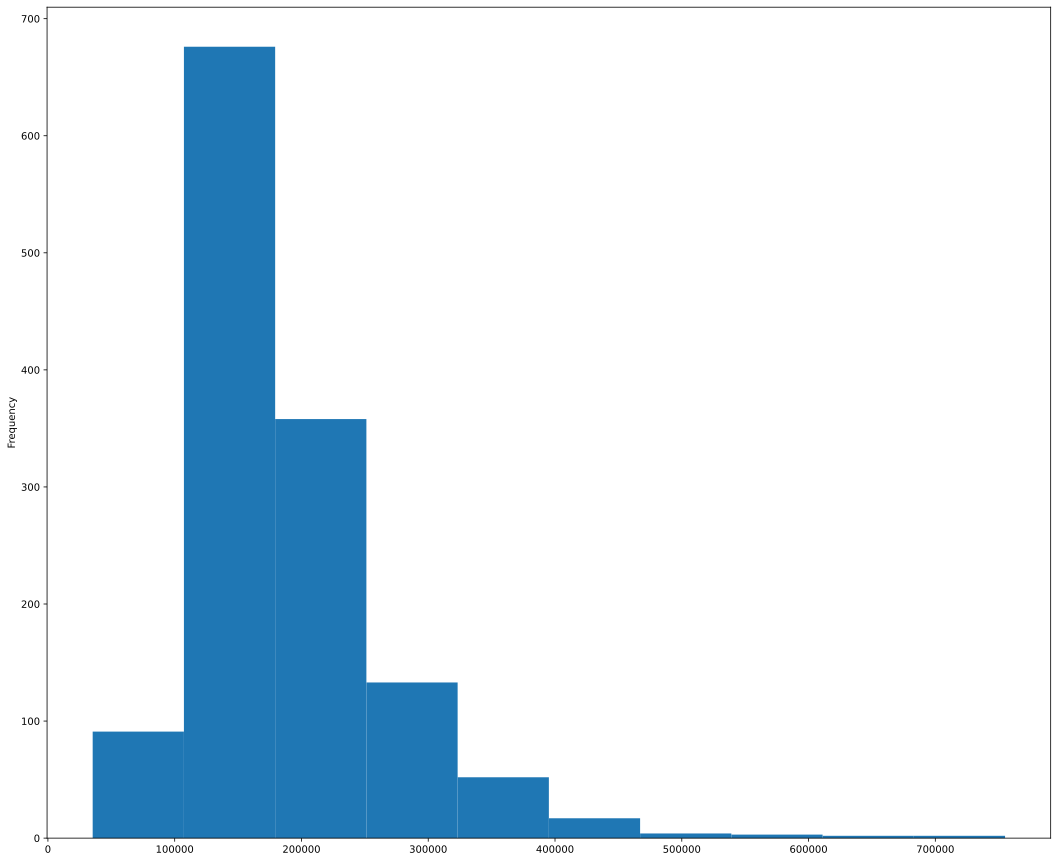

In [83]:
# гистограмма схожа, но не подчиняется нормальному распределению
df['SalePrice'].plot.hist()

In [84]:
stat, p = scipy.stats.normaltest(df['SalePrice'])  # Критерий согласия Пирсона
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальном распределении')
else:
    print('Отклонить гипотезу о нормальном распределении')

Statistics=580.574, p-value=0.000
Отклонить гипотезу о нормальном распределении


In [85]:
stat, p = scipy.stats.shapiro(df['SalePrice'])  # тест Шапиро-Уилк
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

Statistics=0.861, p-value=0.000
Отклонить гипотезу о нормальности


5 Построить коробочную диаграмму (ящик с усами) признака SalePrice всех домов в данных.

<Axes: >

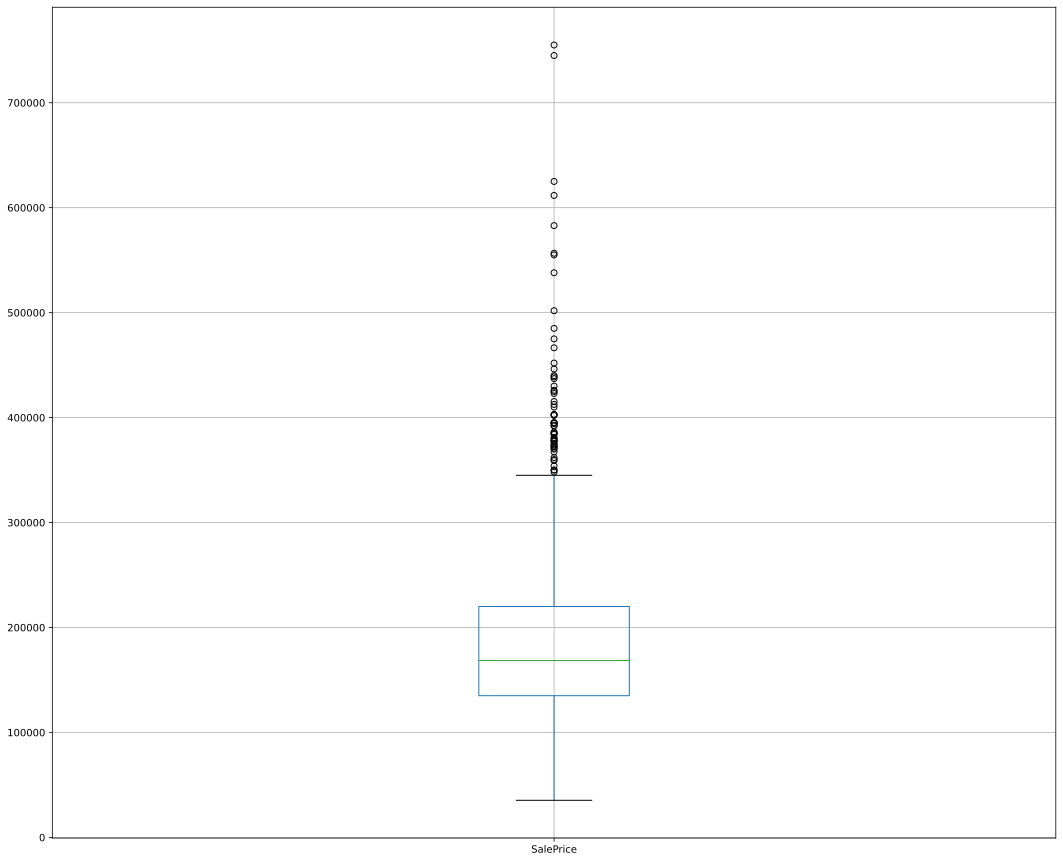

In [86]:
# отображает то же, что и гистограмма - распределение не нормальное, есть выбросы
df.boxplot(column=['SalePrice'])

6 Постройте Гистограммы и Боксплоты по группам:

6.1. кондиционером ('CentralAir') и без кондиционера

<Axes: title={'center': 'SalePrice'}, xlabel='CentralAir'>

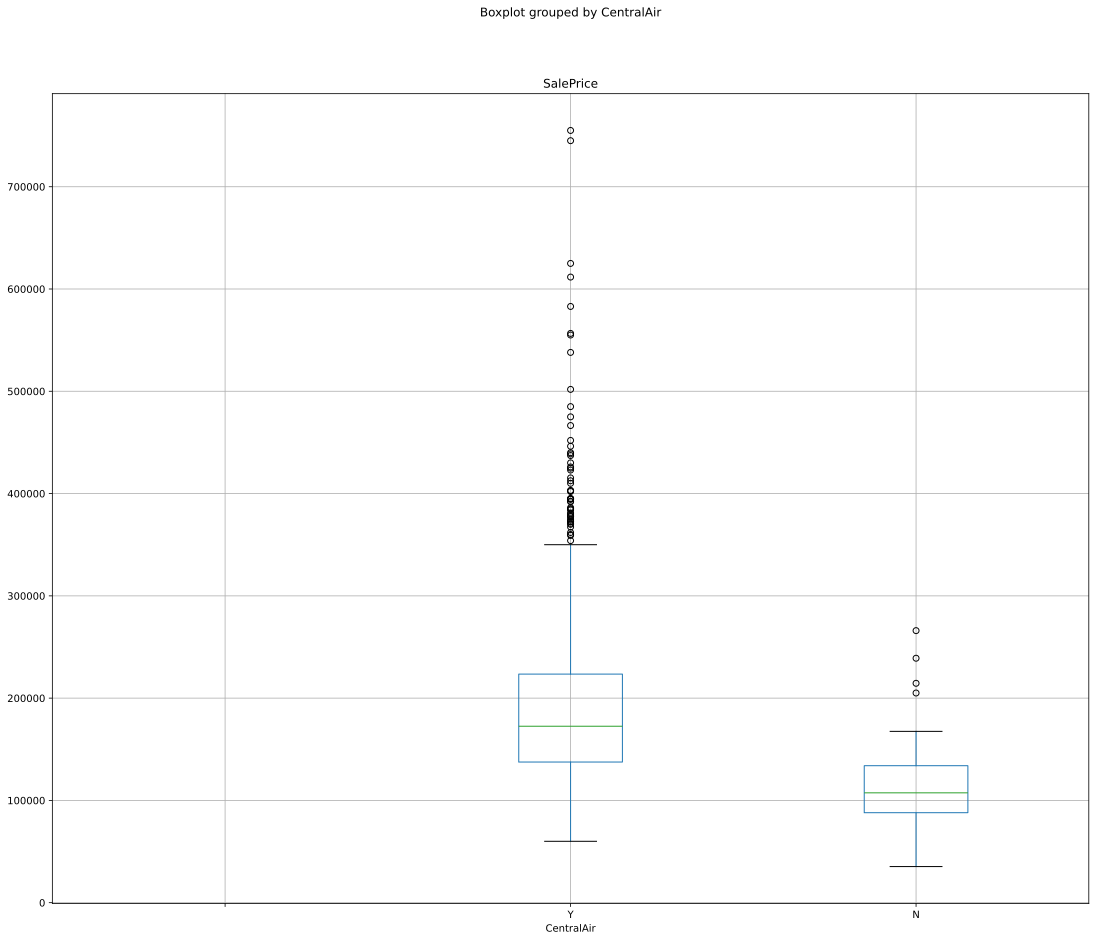

In [87]:
df.boxplot(column='SalePrice', by='CentralAir')

<Axes: title={'center': 'SalePrice'}, xlabel='CentralAir'>

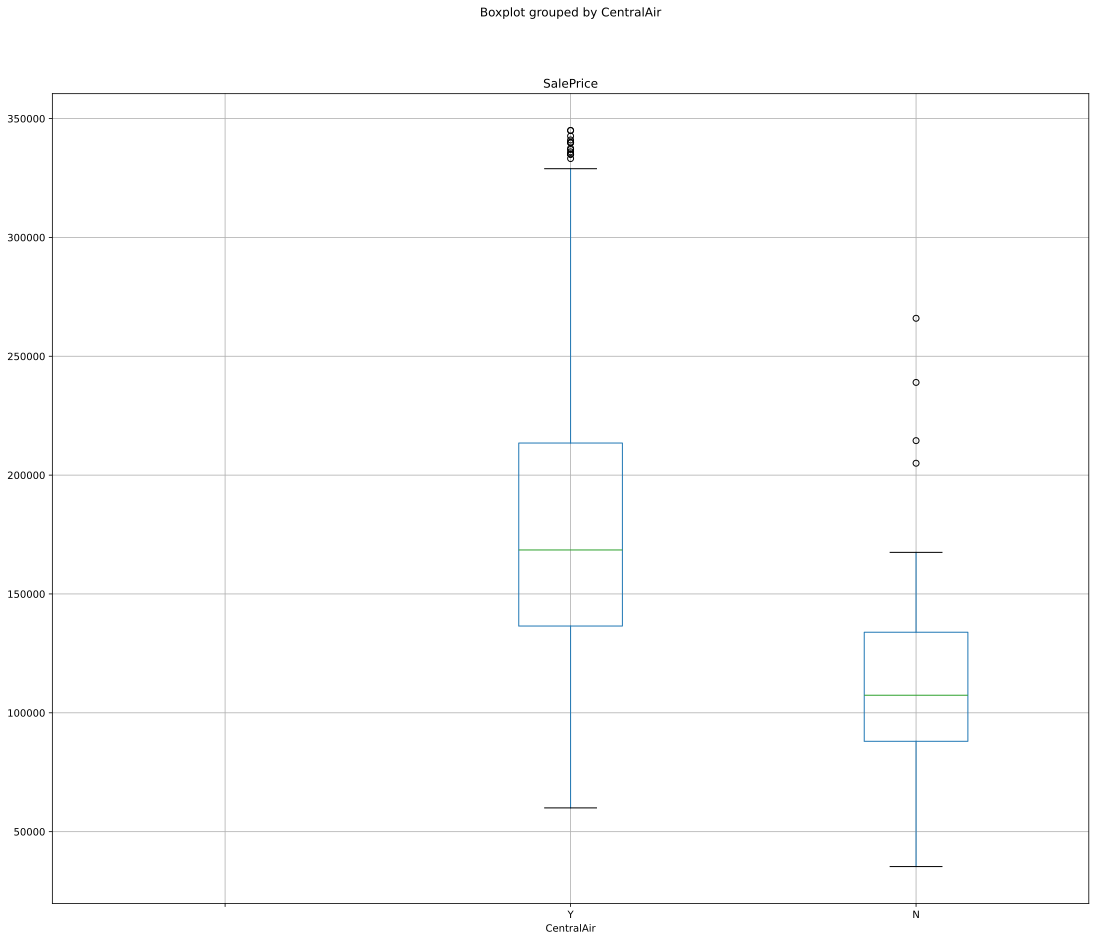

In [88]:
# чуть более 'чистые' ящики с усами
Q1 = df['SalePrice'].quantile(0.25)
Q3 = df['SalePrice'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_cl = df[(df['SalePrice'] >= lower_bound) & (df['SalePrice'] <= upper_bound)]
df_cl.boxplot(column='SalePrice', by='CentralAir')

6.2.цены продажи домов (параметр 'SalePrice'), сгруппированные по размеру гаража (параметр 'GarageCars')

<Axes: title={'center': 'SalePrice'}, xlabel='GarageCars'>

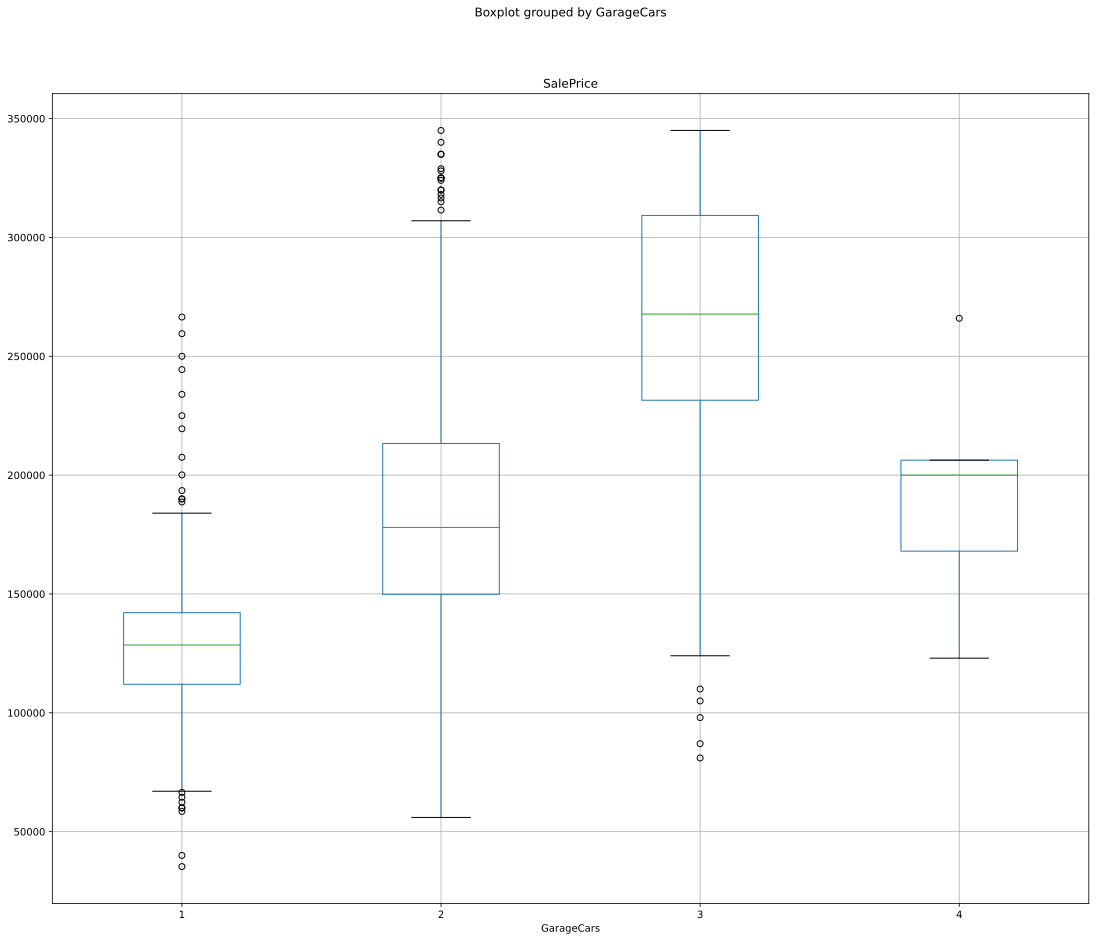

In [89]:
# df.boxplot(column='SalePrice', by='GarageCars')
df_cl.boxplot(column='SalePrice', by='GarageCars')

7 Постройте гистограмму частот:

7.1. частот размеров гаража

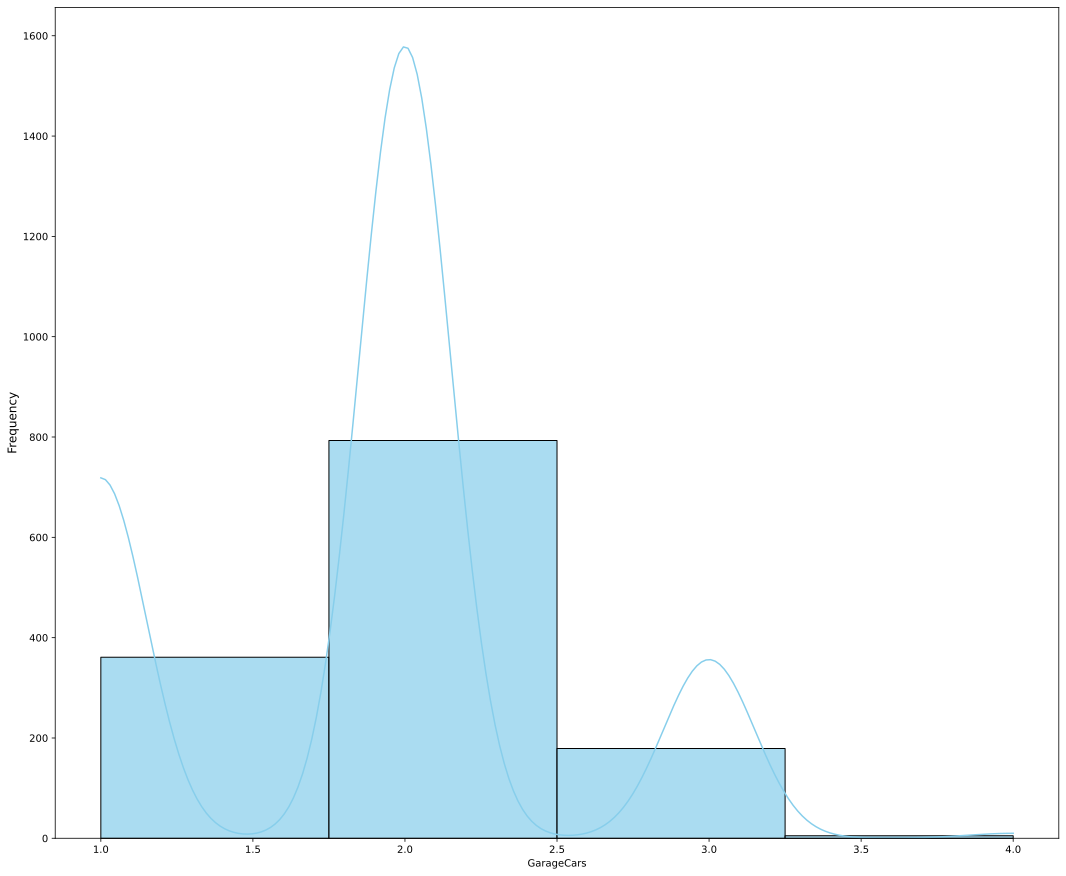

In [90]:
sns.histplot(df['GarageCars'], bins=4, color="skyblue", edgecolor="black", alpha=0.7, kde=True)
plt.ylabel("Frequency", fontsize=12)
plt.show()

7.2. частот центрального кондиционирования

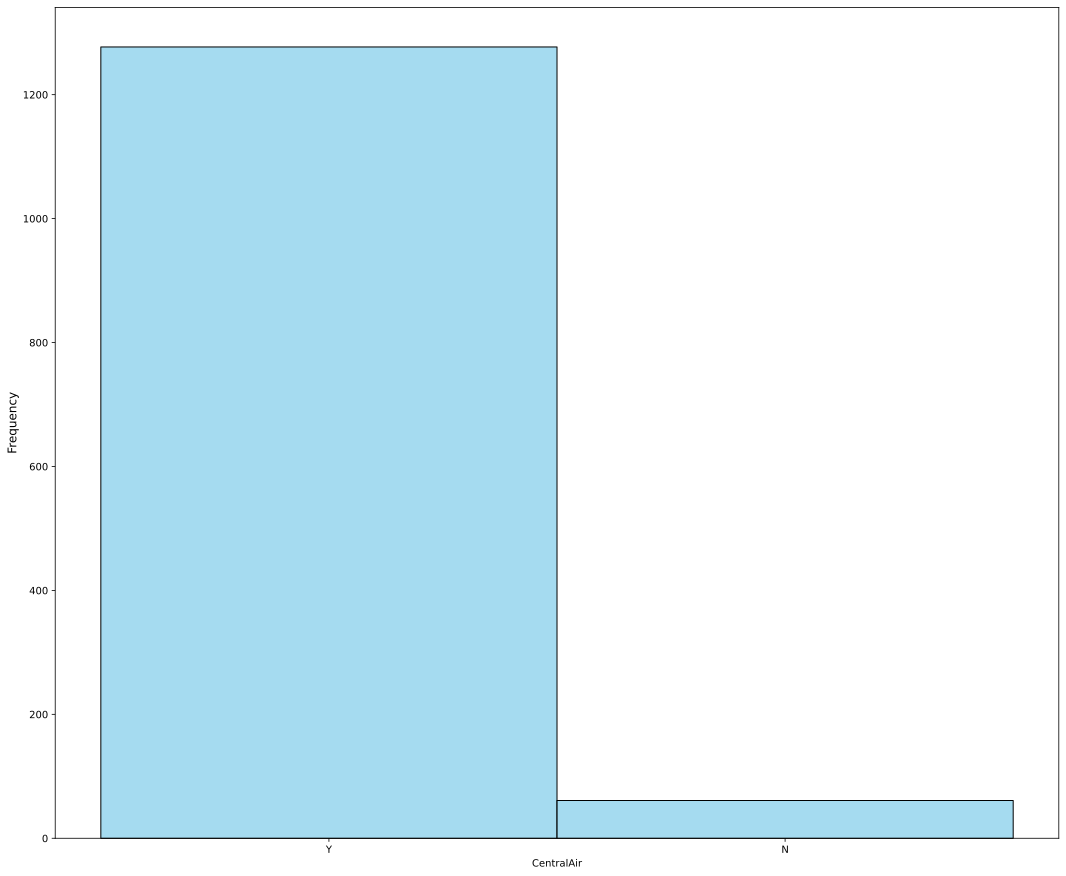

In [91]:
sns.histplot(df['CentralAir'], color="skyblue", edgecolor="black")
plt.ylabel("Frequency", fontsize=12)
plt.show()

8 Рассчитайте долю домов

8.1. с продажной ценой между 25-м процентилем и 75-м процентилем

In [92]:
Q1 = df['SalePrice'].quantile(0.25)
Q3 = df['SalePrice'].quantile(0.75)
IQR = Q3 - Q1
print((len(df[(df['SalePrice'] >= Q1) & (df['SalePrice'] <= Q3)]) / len(df['SalePrice'])) * 100)

50.672645739910315


8.2. с общей площадью в квадратных футах от 25-го процентиля до 75-го процентиля

In [93]:
Q1 = df['LotArea'].quantile(0.25)
Q3 = df['LotArea'].quantile(0.75)
IQR = Q3 - Q1
print((len(df[(df['LotArea'] >= Q1) & (df['LotArea'] <= Q3)]) / len(df['LotArea'])) * 100)

49.92526158445441


9 Получите ковариационную матрицу для всех данных DataFrame и используйте анализ тепловой карты.

In [94]:
df.cov(numeric_only=True)

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.778981e+05,291.004021,-1.573152e+05,-24.834134,5.388555,-2.942139e+02,-243.411134,-9.518226e+02,-344.044712,-1.892041e+03,-3.187909e+03,1.589974e+03,-5.321946e+02,-823.524251,2.342550e+02,2.220459,-2.888201,-0.077112,-2.806484,13.526099,1.019336,15.277993,-4.856029,2.621044,1.075878e+03,-1.764441e+03,-1.470071e+02,131.035355,-557.932162,22.139211,1052.251906,-472.654762,23.840282,1.257638,-1.014272e+06
MSSubClass,2.910040e+02,1701.775051,-5.720668e+04,2.824240,-4.365405,6.885243e+01,32.246267,-1.306931e+03,-543.883111,-2.559482e+03,-4.410296e+03,-4.127679e+03,5.571219e+03,33.573374,1.477113e+03,-0.240723,-0.001509,2.659134,4.108215,-2.104996,1.723679,0.949055,-0.658989,0.179803,-5.414539e+02,-5.353407e+01,-9.681504e-01,-56.721030,-51.608559,-54.476462,17.654522,-450.858458,-1.813309,-1.185216,-2.591250e+05
LotArea,-1.573152e+05,-57206.677332,1.068457e+08,1238.319690,15.772635,-1.534653e+03,352.767726,9.965965e+05,189817.403153,-6.634486e+04,1.120069e+06,1.153027e+06,2.174386e+05,4094.346704,1.374560e+06,856.444388,115.966453,655.015152,31.542469,966.345025,-22.773208,3041.804241,1754.927749,906.266753,3.255384e+05,2.212402e+05,5.738918e+04,-11300.542968,6037.742061,23095.766577,33419.646131,214390.103592,3.279174,-165.971158,2.078062e+08
OverallQual,-2.483413e+01,2.824240,1.238320e+03,1.754225,-0.232869,2.234512e+01,14.770636,1.199768e+02,-18.933554,1.706967e+02,2.717400e+02,2.468210e+02,1.639630e+02,-0.900718,4.098833e+02,0.056857,-0.020791,0.420948,0.166466,0.084347,-0.031256,0.929901,0.322568,0.497228,1.311240e+02,3.692060e+01,2.663047e+01,-9.423010,1.059634,3.479683,3.588574,-19.750355,0.223964,-0.024585,8.189553e+04
OverallCond,5.388555e+00,-4.365405,1.577264e+01,-0.232869,1.162351,-1.330162e+01,0.767547,-2.971150e+01,6.396296,-7.638356e+01,-9.969877e+01,-6.005395e+01,5.546954e+00,1.837596,-5.266940e+01,-0.038963,0.031182,-0.125084,-0.039990,0.019410,-0.013356,-0.109170,-0.022204,-0.170843,-4.125807e+01,-1.780219e+00,-4.258372e+00,4.688457,0.775178,3.364611,-0.160321,42.348300,-0.034261,0.080828,-9.241872e+03
YearBuilt,-2.942139e+02,68.852427,-1.534653e+03,22.345124,-13.301616,8.740029e+02,370.315567,3.041809e+03,-345.912873,1.921861e+03,4.617757e+03,3.012938e+03,9.098092e+01,-192.927193,2.910992e+03,2.669327,-0.394436,7.879997,3.392886,-1.851701,-0.909623,4.658599,2.114211,9.827235,2.450670e+03,8.004495e+02,4.189203e+02,-693.269476,25.896895,-121.522764,1.248012,-503.065353,0.350829,-0.310712,1.176512e+06
YearRemodAdd,-2.434111e+02,32.246267,3.527677e+02,14.770636,0.767547,3.703156e+02,411.946392,9.282116e+02,-287.627017,1.534798e+03,2.175383e+03,1.898228e+03,1.077312e+03,-53.211418,2.922329e+03,1.039155,-0.117563,5.113643,1.734075,-1.172721,-0.546564,5.619060,1.178300,5.914774,1.463979e+03,5.204469e+02,3.066228e+02,-269.769727,24.183677,-61.873325,2.856870,-14.223484,0.797311,0.931875,8.031350e+05
BsmtFinSF1,-9.518226e+02,-1306.930973,9.965965e+05,119.976817,-29.711499,3.041809e+03,928.211640,2.104905e+05,-4945.195607,-1.115824e+05,9.396293e+04,7.989030e+04,-3.068170e+04,-969.587659,4.823901e+04,150.952314,6.345543,11.328570,-5.841056,-42.439434,-2.855189,33.658397,72.640463,57.490176,2.434270e+04,1.095236e+04,3.225515e+03,-2949.720899,371.777870,1382.443270,2747.345336,1834.303008,-26.307552,14.626789,1.302212e+07
BsmtFinSF2,-3.440447e+02,-543.883111,1.898174e+05,-18.933554,6.396296,-3.459129e+02,-287.627017,-4.945196e+03,27621.304619,-1.706937e+04,5.606735e+03,6.044545e+03,-7.995236e+03,47.849053,-1.902842e+03,13.281148,2.924699,-8.231146,-3.225602,-1.055721,-0.821039,-11.118640,3.823165,-8.461080,-1.657837e+03,1.297336e+03,4.574608e+01,461.798027,-

<Axes: >

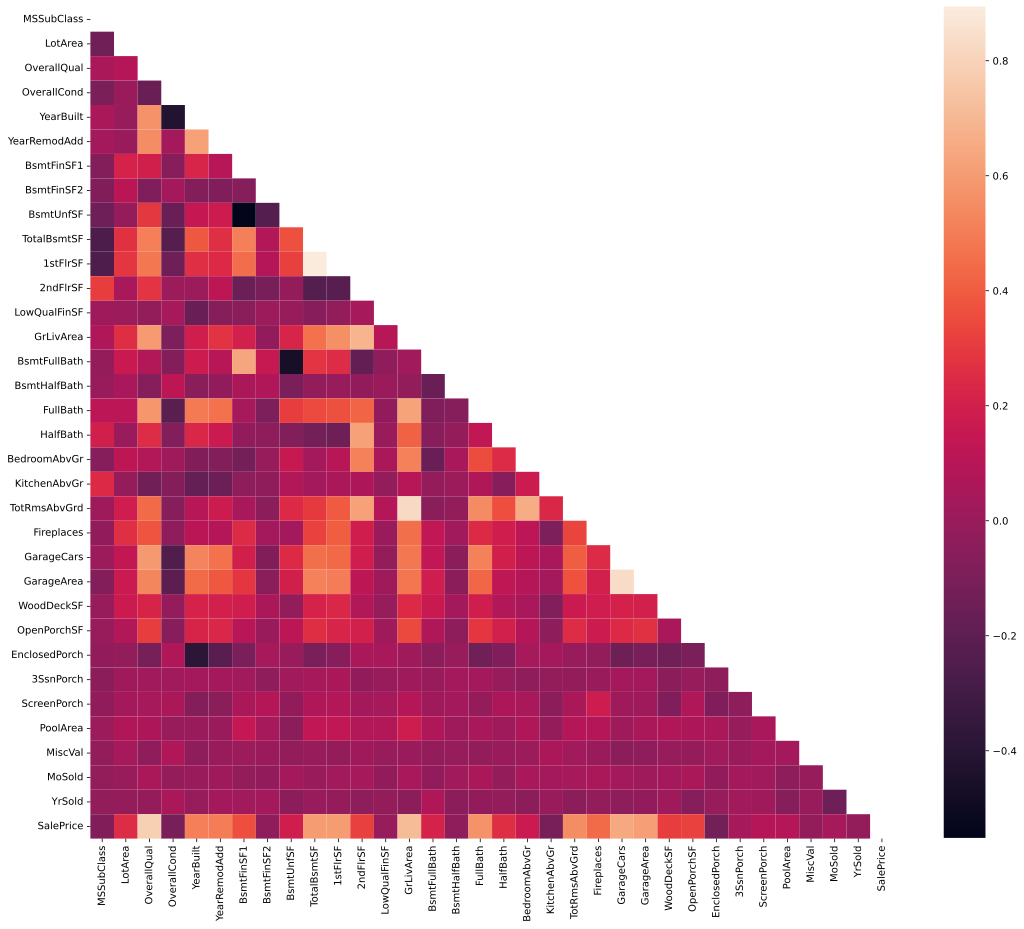

In [95]:
plt.rcParams["figure.figsize"] = (18, 15)
data = df.loc[:, ~df.columns.isin(['Id'])].corr(numeric_only=True)
sns.heatmap(data, mask=np.triu(np.ones_like(data)))

Выведетите 10 параметров с наибольшей корреляцией с SalePrice

In [96]:
df.corr(numeric_only=True).abs().unstack().sort_values(kind="quicksort", ascending=False)["SalePrice"][:10]

SalePrice       1.000000
OverallQual     0.783546
GrLivArea       0.711706
GarageCars      0.640154
GarageArea      0.607535
1stFlrSF        0.604714
TotalBsmtSF     0.602042
FullBath        0.569313
TotRmsAbvGrd    0.551821
YearBuilt       0.504297
dtype: float64